In [17]:
import numpy as np
import skimage as sk
import matplotlib.pyplot as plt
import tifffile as tiff
from scipy.ndimage import gaussian_filter, zoom, rotate
import cv2
from copy import copy

In [2]:
fake_im = sk.io.imread('./../ppujol/benchmarking/dome2_intensities_variation_tp2.tif')
real_im = sk.io.imread('./../ppujol/NiceDomes/62.tif')
real_im = real_im[0]

real_im_r = np.transpose(real_im, axes=(1,0,2))
fake_im_r = np.transpose(fake_im, axes=(1,0,2))

Shape of the real image = (290, 526, 526)
Shape of the fake image = (334, 334, 334)
Max intensity of the real image = 1703
Max intensity of the fake image = 65535
Min intensity of the real image = 0
Min intensity of the fake image = 0
Brightness - Mean intensity of the real image = 26.20035591238052
Brightness - Mean intensity of the fake image = 11556.46442937389
Contrast - Std intensity of the real image = 42.70399937978572
Contrast - Std intensity of the fake image = 3727.9621529273895


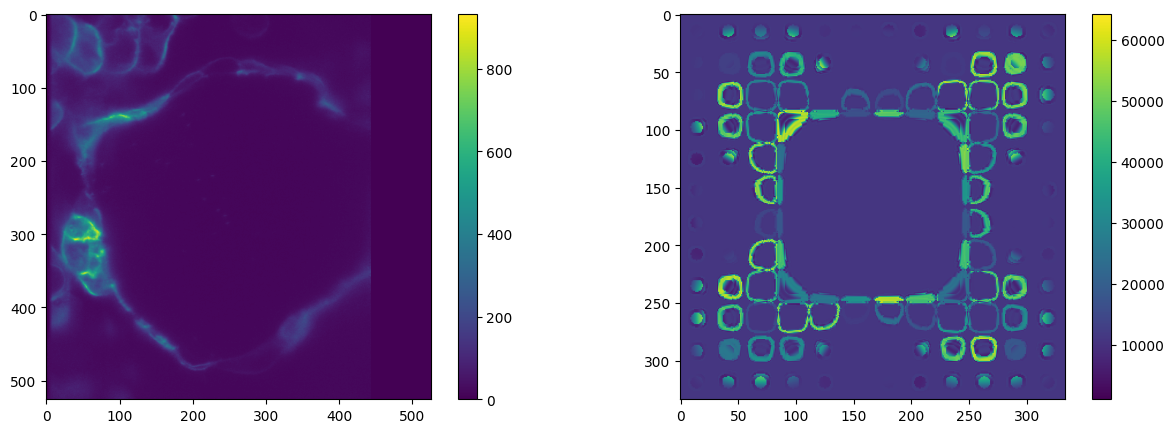

In [3]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(real_im[200])
plt.colorbar()
plt.subplot(122)
plt.imshow(fake_im[300])
plt.colorbar()

print(f"Shape of the real image = {real_im.shape}")
print(f"Shape of the fake image = {fake_im.shape}")

print(f"Max intensity of the real image = {real_im.max()}")
print(f"Max intensity of the fake image = {fake_im.max()}")

print(f"Min intensity of the real image = {real_im.min()}")
print(f"Min intensity of the fake image = {fake_im.min()}")

print(f"Brightness - Mean intensity of the real image = {real_im.mean()}")
print(f"Brightness - Mean intensity of the fake image = {fake_im.mean()}")

print(f"Contrast - Std intensity of the real image = {real_im.std()}")
print(f"Contrast - Std intensity of the fake image = {fake_im.std()}")

In [4]:
def normalize_image(im, mult_factor = 1):
    '''
    Normalize image 0-1 and multiply by any factor
    '''
    norm_im = (im - im.min()) / (im.max()-im.min()) * mult_factor
    return norm_im

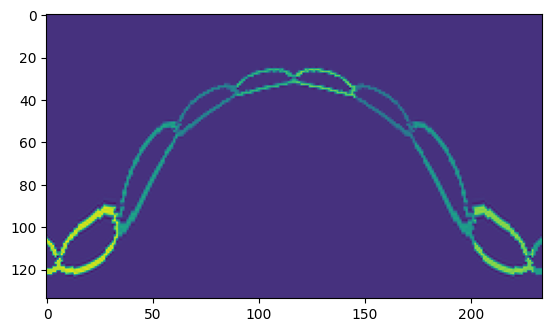

In [5]:
plt.imshow(fake_im_r[50:284, 200:, 50:284][100]) # Check the cut

(234, 134, 234)
[2.247863247863248, 2.1641791044776117, 2.247863247863248]


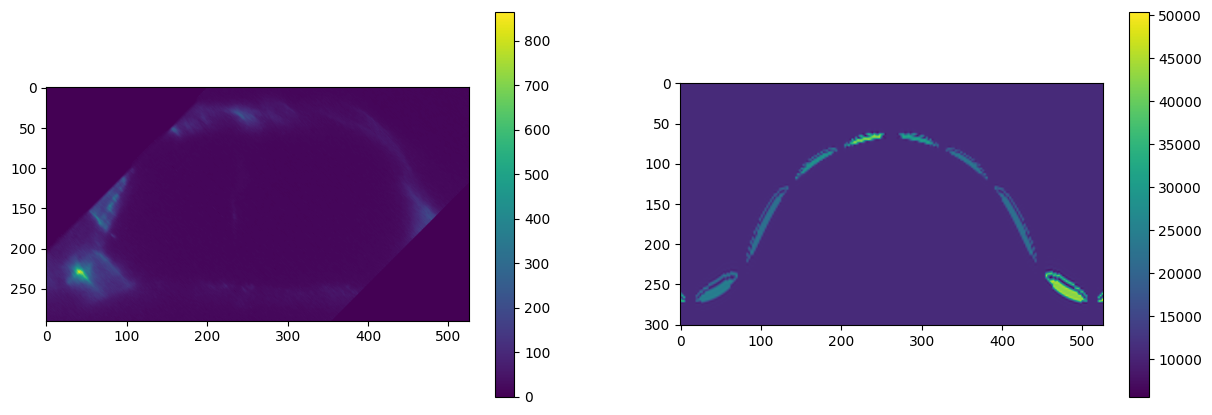

In [6]:
fake_im_r = fake_im_r[50:284, 200:, 50:284] # cut the image. This is before amplification
print(fake_im_r.shape)
amplifications = [real_im_r.shape[i]/fake_im_r.shape[i] for i in range(len(real_im.shape))]
print(amplifications)
fake_im_r = zoom(fake_im_r, (max(amplifications), max(amplifications), max(amplifications)), order=1) # amplify to the same size as the real
# fake_im_r = fake_im_r[:, 300:, :] # cut the image. This is after amplification


plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(real_im_r[int(real_im_r.shape[0]/2)])
plt.colorbar()
plt.subplot(122)
plt.imshow(fake_im_r[int(fake_im_r.shape[0]/2)])
plt.colorbar()

fake_im = np.transpose(fake_im_r, axes=(1, 2, 0))

Shape of the real image = (290, 526, 526)
Shape of the fake image = (301, 526, 526)
Max intensity of the real image = 1703
Max intensity of the fake image = 426
Min intensity of the real image = 0
Min intensity of the fake image = 25
Brightness - Mean intensity of the real image = 26.20035591238052
Brightness - Mean intensity of the fake image = 34.78943765208129
Contrast - Std intensity of the real image = 42.70399937978572
Contrast - Std intensity of the fake image = 42.680882661777375


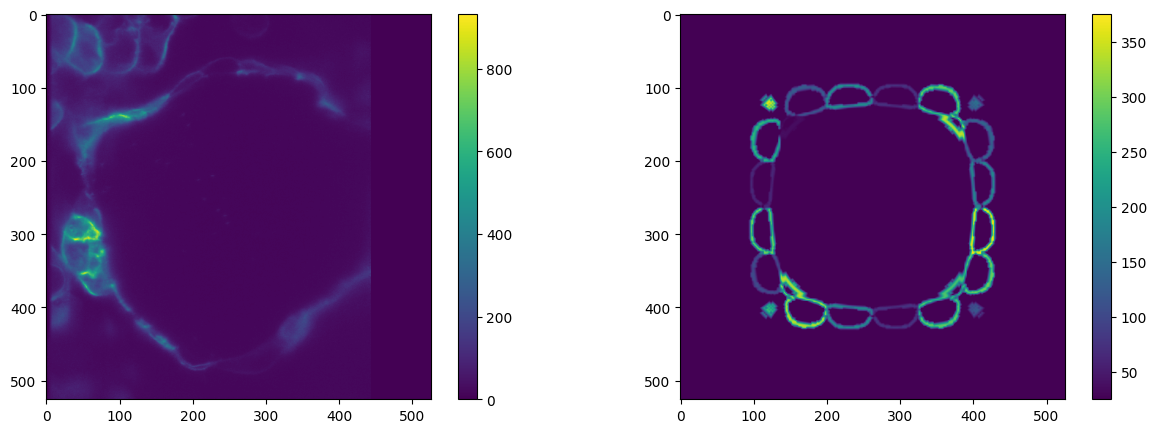

In [7]:
fake_im_modified = copy(fake_im)

### ???
fake_im_modified = normalize_image(fake_im, real_im.max())
fake_im_modified = np.clip(fake_im_modified.astype(int) - (fake_im_modified.mean()-real_im.mean()), 0, 65535).astype(np.uint16) # adjust brightness
fake_im_modified = np.clip((fake_im_modified - fake_im_modified.mean()) * real_im.std()/fake_im_modified.std() + fake_im_modified.mean(), 0, 65535).astype(np.uint16) # adjust contrast
### ???




plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(real_im[200])
plt.colorbar()
plt.subplot(122)
plt.imshow(fake_im_modified[150])
plt.colorbar()



print(f"Shape of the real image = {real_im.shape}")
print(f"Shape of the fake image = {fake_im_modified.shape}")

print(f"Max intensity of the real image = {real_im.max()}")
print(f"Max intensity of the fake image = {fake_im_modified.max()}")

print(f"Min intensity of the real image = {real_im.min()}")
print(f"Min intensity of the fake image = {fake_im_modified.min()}")

print(f"Brightness - Mean intensity of the real image = {real_im.mean()}")
print(f"Brightness - Mean intensity of the fake image = {fake_im_modified.mean()}")

print(f"Contrast - Std intensity of the real image = {real_im.std()}")
print(f"Contrast - Std intensity of the fake image = {fake_im_modified.std()}")

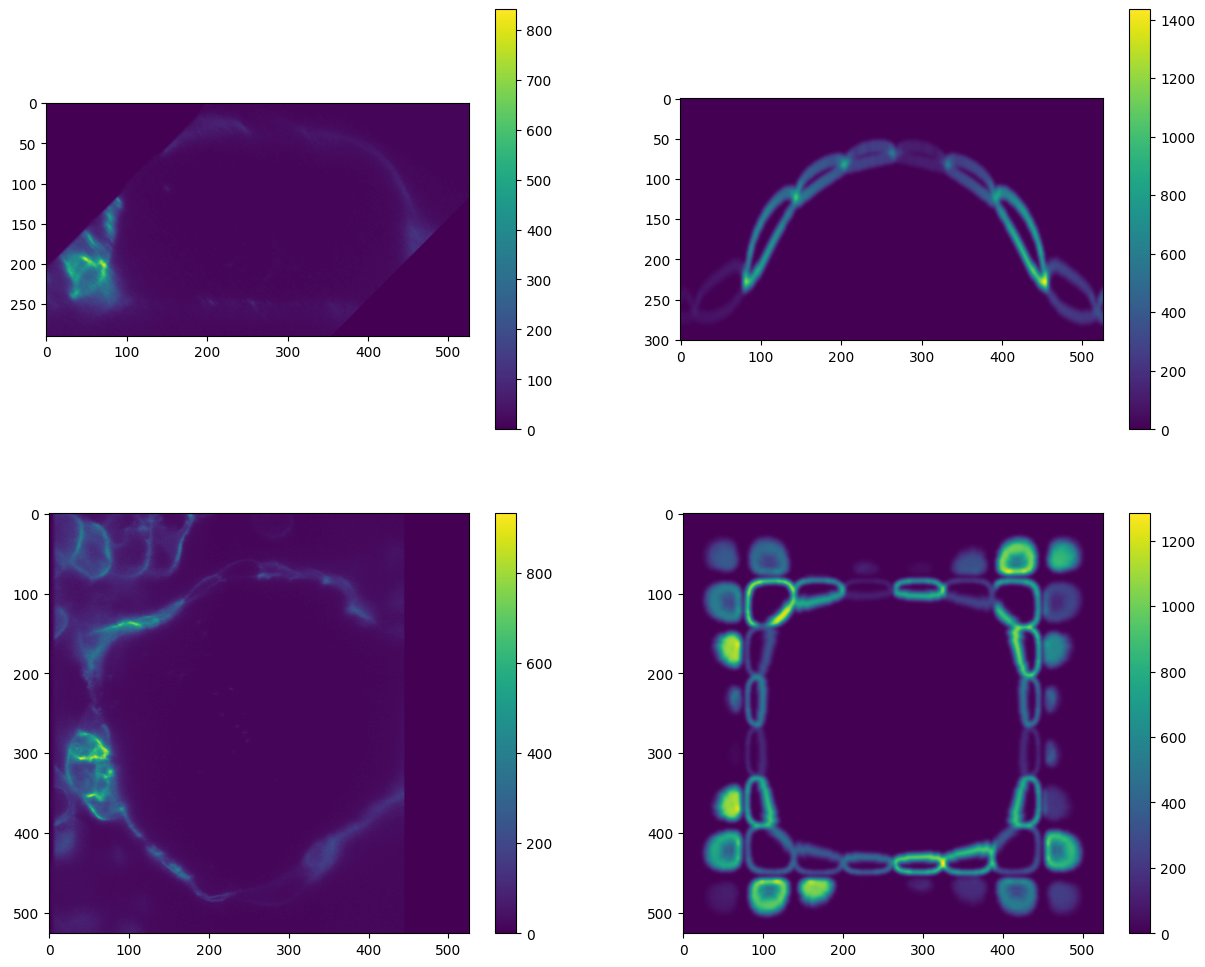

In [8]:
fake_im_modified = fake_im_modified.astype(np.float64)
fake_im_modified_blur = gaussian_filter(fake_im_modified, 2)
# fake_im_modified_blur = normalize_image(fake_im_modified_blur, 65535).astype(np.uint16)
fake_im_modified_blur = normalize_image(fake_im_modified_blur, real_im.max()).astype(np.uint16)



fake_im_modified_blur_r = np.transpose(fake_im_modified_blur, axes=(1,0,2))
size = 15
kernel_z = np.zeros((size, size))
kernel_z[:, 2] = 1
kernel_z = kernel_z/kernel_z.sum()

fake_im_modified_movement_r = np.zeros_like(fake_im_modified_blur_r)
for i in range(fake_im_modified_blur_r.shape[0]):
    slice_movement_r = fake_im_modified_blur_r[i]
    slice_movement_r = cv2.filter2D(slice_movement_r, -1, kernel_z)
    fake_im_modified_movement_r[i] = slice_movement_r

fake_im_modified_movement = np.transpose(fake_im_modified_movement_r, axes=(1, 2, 0))

plt.figure(figsize=(15, 12))
plt.subplot(221)
plt.imshow(real_im_r[300])
plt.colorbar()
plt.subplot(222)
plt.imshow(fake_im_modified_movement_r[300])
plt.colorbar()

plt.subplot(223)
plt.imshow(real_im[200])
plt.colorbar()
plt.subplot(224)
plt.imshow(fake_im_modified_movement[200])
plt.colorbar()

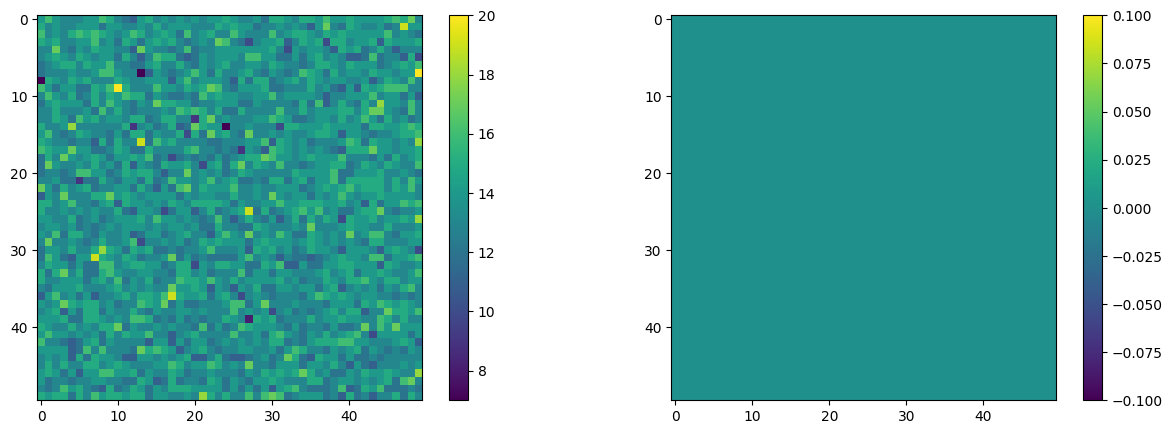

In [9]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(real_im[0][300:350, 300:350])
plt.colorbar()
plt.subplot(122)
plt.imshow(fake_im_modified_movement[0][300:350, 300:350])
plt.colorbar()

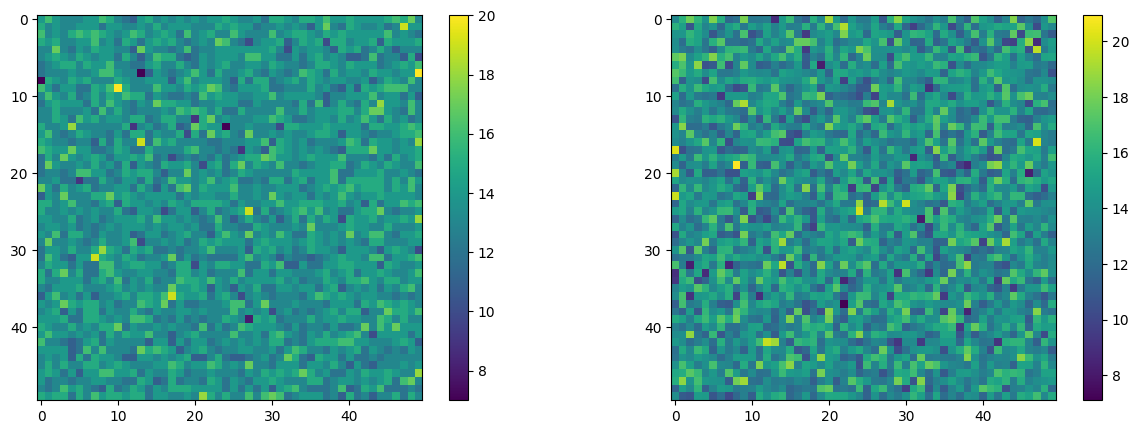

In [10]:
fake_im_modified_noisy = copy(fake_im_modified_movement)+np.random.normal(0, 2, fake_im_modified_movement.shape)+2*7
fake_im_modified_noisy_r = np.transpose(fake_im_modified_noisy, axes=(1,0,2))


plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(real_im[0][300:350, 300:350])
plt.colorbar()
plt.subplot(122)
plt.imshow(fake_im_modified_noisy[0][300:350, 300:350])
plt.colorbar()

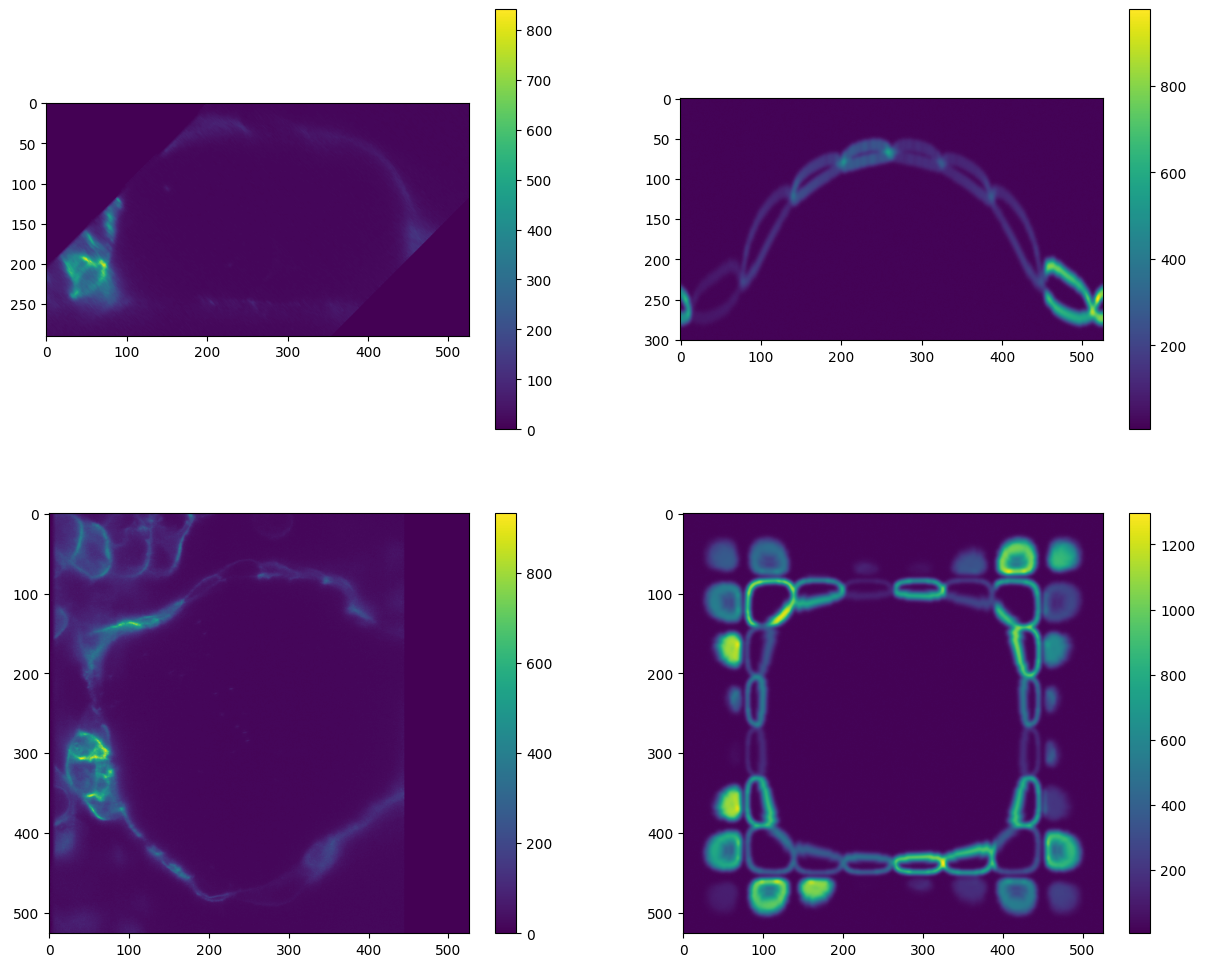

In [11]:
plt.figure(figsize=(15, 12))
plt.subplot(221)
plt.imshow(real_im_r[300])
plt.colorbar()
plt.subplot(222)
plt.imshow(fake_im_modified_noisy_r[300])
plt.colorbar()

plt.subplot(223)
plt.imshow(real_im[200])
plt.colorbar()
plt.subplot(224)
plt.imshow(fake_im_modified_noisy[200])
plt.colorbar()

(290, 526)
Shape of the real image = (290, 526, 526)


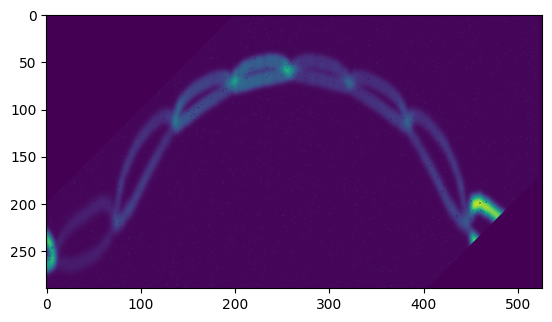

In [65]:
new_image = rotate(rotate(fake_im_modified_sap_r[300], -45)[150:500, :], 45, reshape=False)
new_image = new_image[10:300, 10:536]
print(new_image.shape)
print(f"Shape of the real image = {real_im.shape}")


plt.imshow(new_image)

fake_im_black_strip_r = np.zeros((real_im_r.shape))

for i in range(fake_im_modified_sap_r.shape[0]):
    rotated = rotate(rotate(fake_im_modified_sap_r[i], -45)[150:500, :], 45, reshape=False)
    fake_im_black_strip_r[i] = rotated[10:300, 10:536]
    print(i, end='\r')

In [12]:
def add_salt_and_pepper_noise(image, salt_ratio=0.05, pepper_ratio=0.05):
    z, y, x = image.shape
    salt = np.random.rand(z, y, x) < salt_ratio
    pepper = np.random.rand(z, y, x) < pepper_ratio
    noisy_image = np.copy(image)
    noisy_image[salt] = image.mean()
    noisy_image[pepper] = 0
    return noisy_image


fake_im_modified_sap = add_salt_and_pepper_noise(fake_im_modified_noisy, salt_ratio=0.005, pepper_ratio=0.005)
fake_im_modified_sap_r = np.transpose(fake_im_modified_sap, axes=(1,0,2))

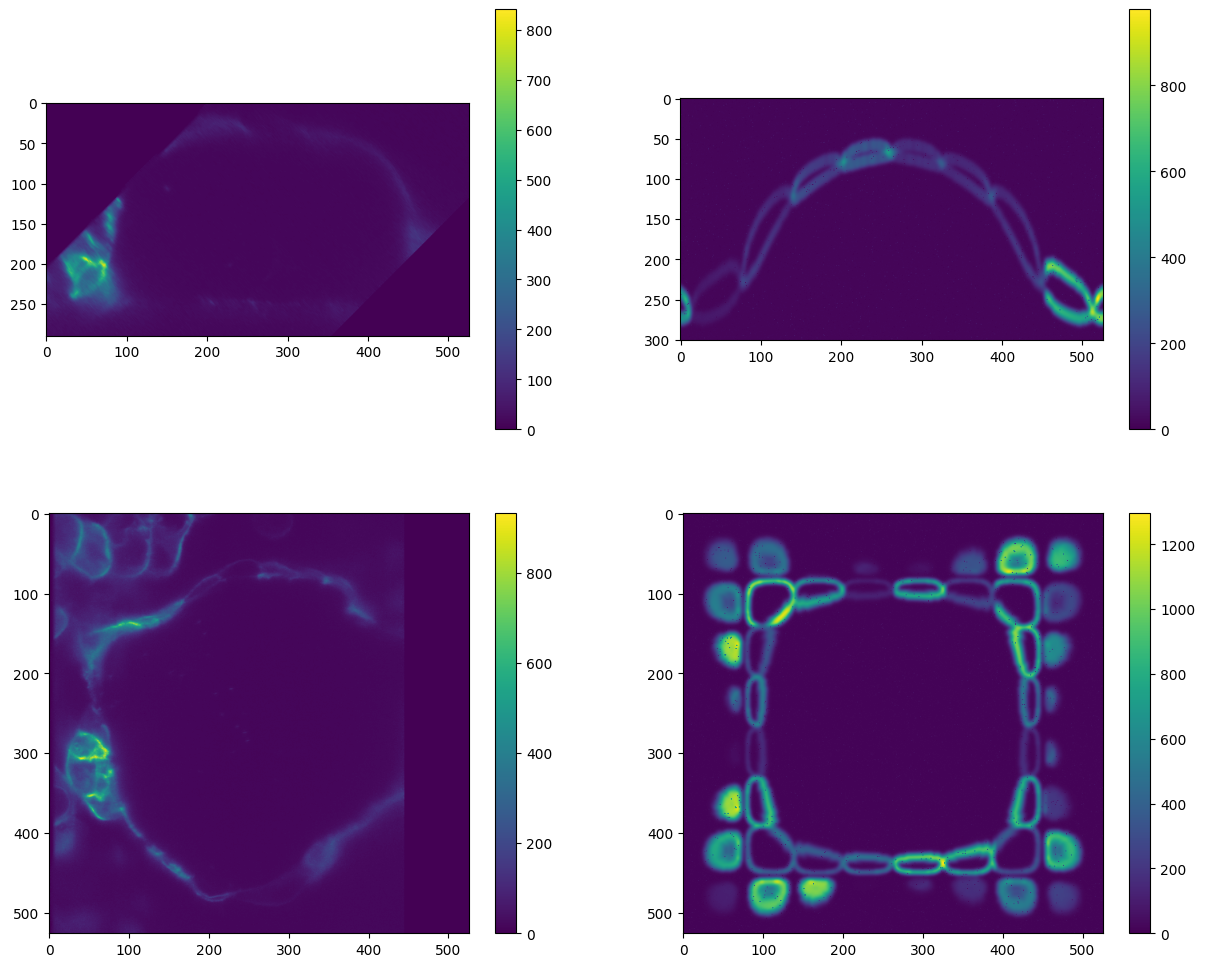

In [13]:
plt.figure(figsize=(15, 12))
plt.subplot(221)
plt.imshow(real_im_r[300])
plt.colorbar()
plt.subplot(222)
plt.imshow(fake_im_modified_sap_r[300])
plt.colorbar()

plt.subplot(223)
plt.imshow(real_im[200])
plt.colorbar()
plt.subplot(224)
plt.imshow(fake_im_modified_sap[200])
plt.colorbar()

In [66]:
fake_im_black_strip = np.transpose(fake_im_black_strip_r, axes=(1, 2, 0))

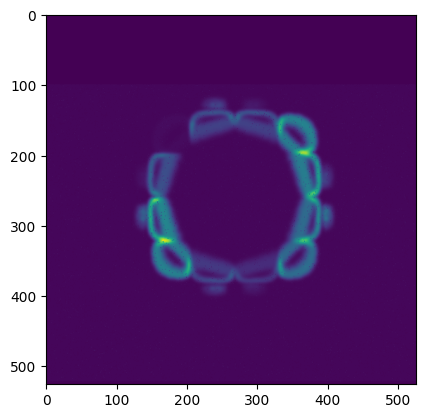

In [77]:
plt.imshow(fake_im_black_strip[100])

In [67]:
tiff.imwrite('./../ppujol/benchmarking/dome2_intensities_variation_tp2_mod.tif', fake_im_black_strip.astype(np.uint16), imagej=True)

# Make the process correct.

In [1]:
import numpy as np
import skimage as sk
import matplotlib.pyplot as plt
import tifffile as tiff
from scipy.ndimage import gaussian_filter, zoom, rotate
import cv2
from copy import copy

In [2]:
## Functions

def get_r(image):
    image_r = np.transpose(image, axes=(1,0,2))
    return image_r

def get_top(image_r):
    image = np.transpose(image_r, axes=(1, 2, 0))
    image = np.rot90(image, axes=(1,2))
    return image

def normalize_image(im, mult_factor=1):
    '''
    Normalize image 0-1 and multiply by any factor
    '''
    norm_im = (im - im.min()) / (im.max()-im.min()) * mult_factor
    return norm_im

def amplify_image(real_im, fake_im):
    amplifications = [real_im.shape[i]/fake_im.shape[i] for i in range(len(real_im.shape))]
    fake_im = zoom(fake_im, (max(amplifications), max(amplifications), max(amplifications)), order=1)
    return fake_im

def realistic_brightness_and_contrast(fake_im, real_im):
    fake_im_modified = normalize_image(fake_im, real_im.max())
    fake_im_modified = np.clip(fake_im_modified.astype(int) - (fake_im_modified.mean()-real_im.mean()), 0, 65535).astype(np.uint16) # adjust brightness
    fake_im_modified = np.clip((fake_im_modified - fake_im_modified.mean()) * real_im.std()/fake_im_modified.std() + fake_im_modified.mean(), 0, 65535).astype(np.uint16) # adjust contrast
    return fake_im_modified

def random_noise(image, sum_to_noise=14):
    image_noise = copy(image)+np.random.normal(0, 2, image.shape)+sum_to_noise
    return image_noise

def blur(image, norm_top=10000):
    fake_im_modified = image.astype(np.float64)
    image_gaussian = gaussian_filter(image, 2)
    # fake_im_modified_blur = normalize_image(fake_im_modified_blur, 65535).astype(np.uint16)
    image_gaussian = normalize_image(image_gaussian, norm_top).astype(np.uint16)
    return image_gaussian

def movement_blur(image, size=15):
    image_r = get_r(image)
    kernel_z = np.zeros((size, size))
    kernel_z[:, 2] = 1
    kernel_z = kernel_z/kernel_z.sum()
    
    image_movement_r = np.zeros_like(image_r)
    for i in range(image_r.shape[0]):
        slice_movement_r = image_r[i]
        slice_movement_r = cv2.filter2D(slice_movement_r, -1, kernel_z)
        image_movement_r[i] = slice_movement_r

    image_movement = get_top(image_movement_r)
    return image_movement

def salt_and_pepper_noise(image, salt_ratio=0.05, pepper_ratio=0.05):
    z, y, x = image.shape
    salt = np.random.rand(z, y, x) < salt_ratio
    pepper = np.random.rand(z, y, x) < pepper_ratio
    noisy_image = np.copy(image)
    noisy_image[salt] = image.mean()
    noisy_image[pepper] = 0
    return noisy_image

def black_45(image, real_image):
    image_r = get_r(image)
    real_image_r = get_r(real_im) 

    non_zero = np.sum(real_image_r, axis=0)
    black_white_r = np.zeros((real_image_r.shape))
    black_white_r[:, non_zero != 0] = 1

    ## Second axis _r
    amplification = image_r.shape[1]/black_white_r.shape[1]
    black_white_r = zoom(black_white_r, (amplification, amplification, amplification), order=1)
    
    ## Third axis _r
    middle_index = black_white_r.shape[2]//2-25
    while (image_r.shape[2] < black_white_r.shape[2]):
        black_white_r = np.concatenate((black_white_r[:, :, :middle_index], black_white_r[:, :, middle_index+50:]), axis=2) ## Remove slices
    
    while (image_r.shape[2] > black_white_r.shape[2]):
        number_slices = image_r.shape[2]-black_white_r.shape[2]
        slice_of_ones = np.ones((black_white_r.shape[0], black_white_r.shape[1], number_slices))
        black_white_r = np.concatenate((black_white_r[:, :, :middle_index], slice_of_ones, black_white_r[:, :, middle_index:]), axis=2) ## Add slices
    
    ##  First axis _r
    middle_index = black_white_r.shape[0]//2-25
    while (image_r.shape[0] < black_white_r.shape[0]):
        black_white_r = np.concatenate((black_white_r[:middle_index, :, :], black_white_r[middle_index+50:, :, :]), axis=0) ## Remove slices
    
    while (image_r.shape[0] > black_white_r.shape[0]):
        number_slices = image_r.shape[0]-black_white_r.shape[0]
        shaped_slices = black_white_r[middle_index, ...]
        shaped_slices = np.expand_dims(shaped_slices, axis=0)
        shaped_slices = np.repeat(shaped_slices, number_slices, axis=0)
        black_white_r = np.concatenate((black_white_r[:middle_index, :, :], shaped_slices, black_white_r[middle_index:, :, :]), axis=0) ## Add slices
    
    return get_top(black_white_r*image_r)

def plotcomparisons(real_im, fake_im, slice_r=300, slice_top=200):
    plt.figure(figsize=(15, 12))
    plt.subplot(221)
    plt.imshow(get_r(real_im)[slice_r])
    plt.colorbar()
    plt.subplot(222)
    plt.imshow(get_r(fake_im)[slice_r])
    plt.colorbar()
    
    plt.subplot(223)
    plt.imshow(real_im[slice_top])
    plt.colorbar()
    plt.subplot(224)
    plt.imshow(fake_im[slice_top])
    plt.colorbar()

    pass

def valuecomparisons(real_im, fake_im):
    print(f"Shape of the real image = {real_im.shape}")
    print(f"Shape of the fake image = {fake_im.shape}")
    
    print(f"Max intensity of the real image = {real_im.max()}")
    print(f"Max intensity of the fake image = {fake_im.max()}")
    
    print(f"Min intensity of the real image = {real_im.min()}")
    print(f"Min intensity of the fake image = {fake_im.min()}")
    
    print(f"Brightness - Mean intensity of the real image = {real_im.mean()}")
    print(f"Brightness - Mean intensity of the fake image = {fake_im.mean()}")
    
    print(f"Contrast - Std intensity of the real image = {real_im.std()}")
    print(f"Contrast - Std intensity of the fake image = {fake_im.std()}")

    pass

In [30]:
tp = str(0)
fake_im = sk.io.imread('./../ppujol/benchmarking/dome2_intensities_variation_tp'+tp+'.tif')
real_im = sk.io.imread('./../ppujol/NiceDomes/62.tif')
real_im = real_im[0]

real_im_r = get_r(real_im)
fake_im_r = get_r(fake_im)

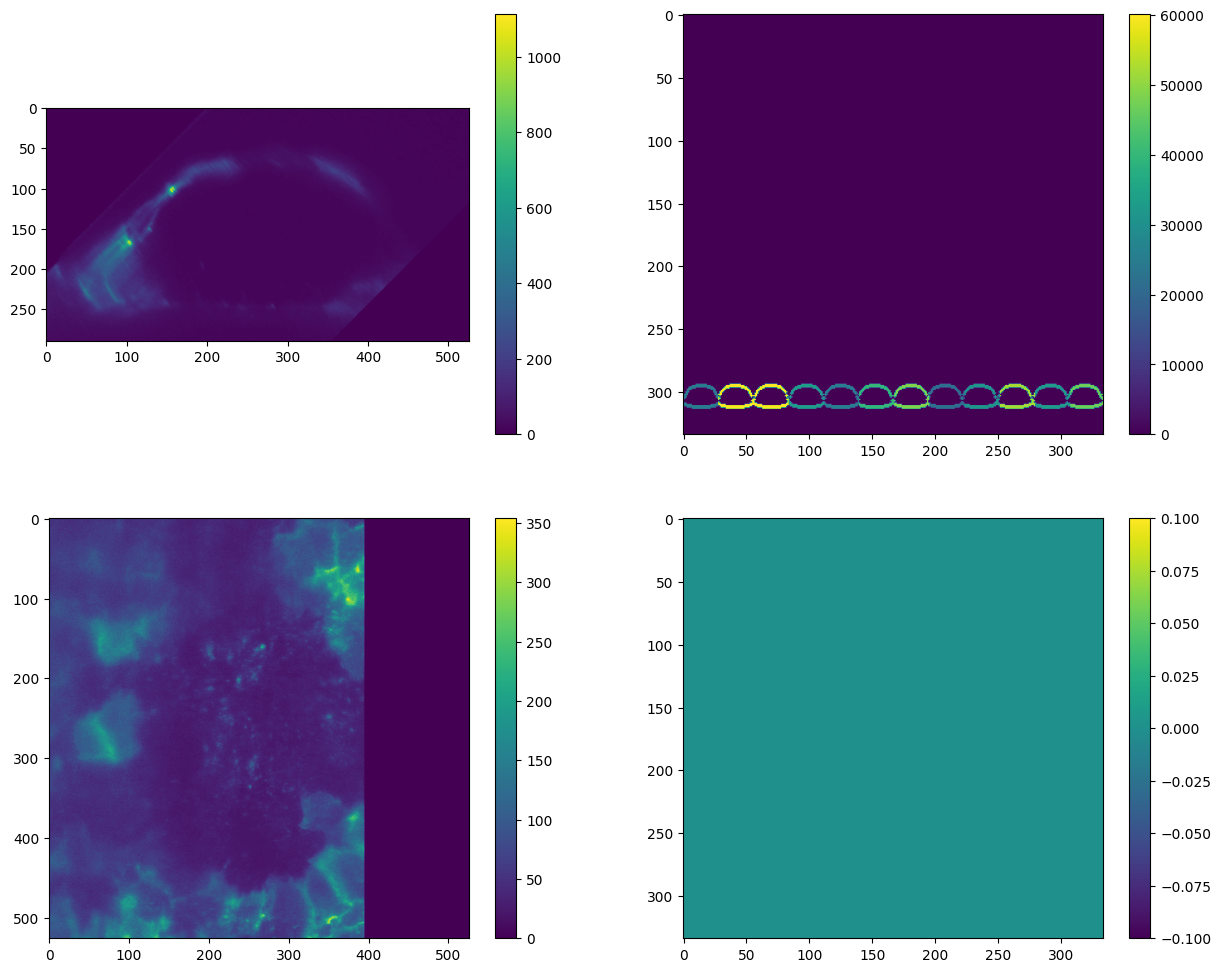

In [31]:
plotcomparisons(real_im, fake_im, slice_r=150, slice_top=250)

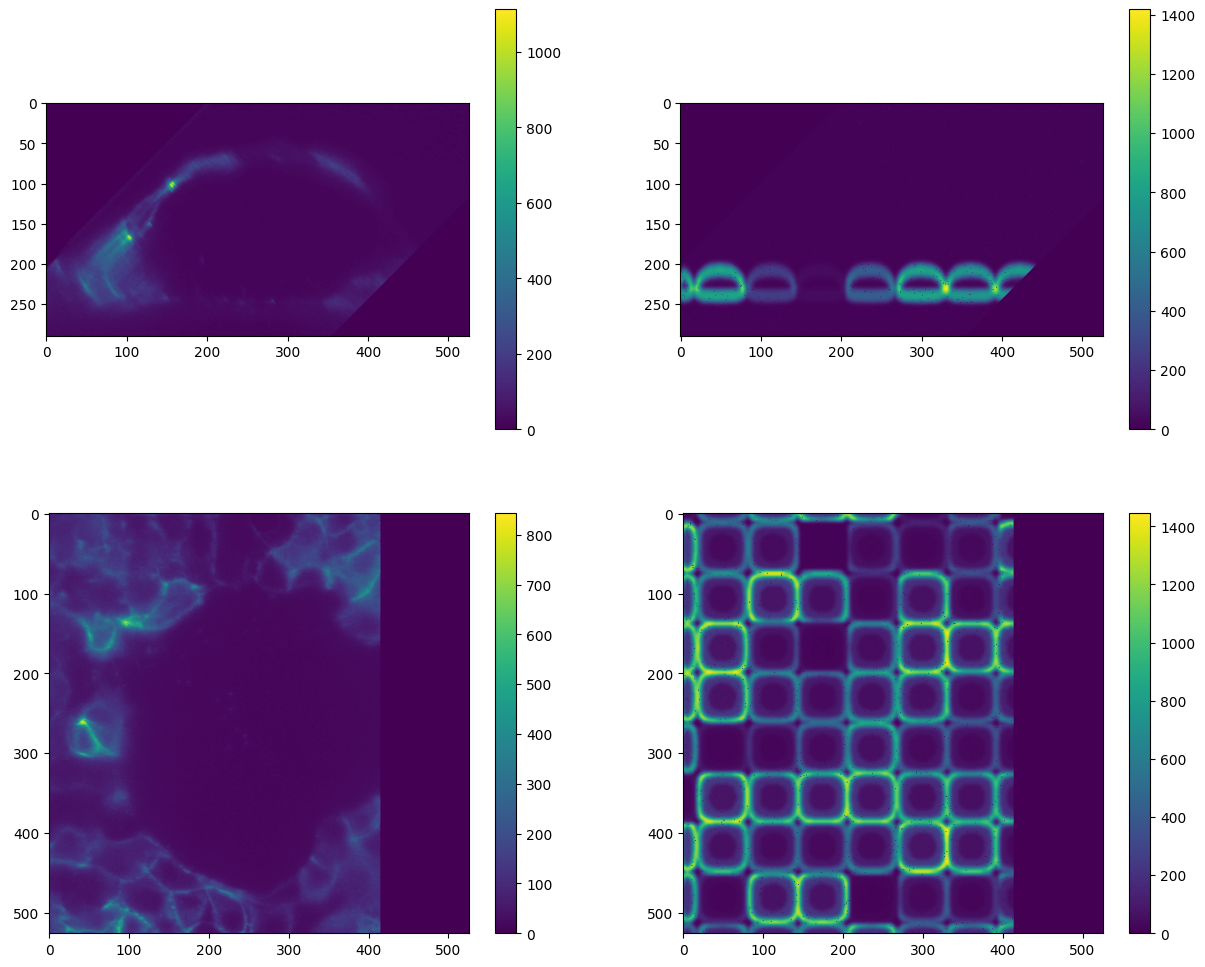

In [32]:
fake_im_cut = copy(fake_im)
fake_im_cut = realistic_brightness_and_contrast(fake_im_cut, real_im)
# valuecomparisons(real_im, fake_im_cut)

if tp == '0':
    fake_im_cut = fake_im_cut[205:, 50:284, 50:284] ## Image of """tp0"""
if tp == '1':
    fake_im_cut = fake_im_cut[205:, 50:284, 50:284] ## Image of """tp1"""
if tp == '2':
    fake_im_cut = fake_im_cut[205:, 50:284, 50:284] ## This is the cut to have the same size as the original image of """tp2"""
if tp == '3':
    fake_im_cut = fake_im_cut[160:, 20:304, 20:304] ## Image of """tp3"""
if tp == '4':
    fake_im_cut = fake_im_cut[180:, 20:314, 20:314] ## Image of """tp4"""
if tp == '5':
    fake_im_cut = fake_im_cut[180:, 20:314, 20:314] ## Image of """tp5"""
if tp == '6':
    fake_im_cut = fake_im_cut[205:, 50:284, 50:284] ## Image of """tp6"""

fake_im_cut = amplify_image(real_im, fake_im_cut)
fake_im_cut = blur(fake_im_cut, norm_top=real_im.max())
fake_im_cut = movement_blur(fake_im_cut, size=15)

fake_im_cut = random_noise(fake_im_cut)
fake_im_cut = salt_and_pepper_noise(fake_im_cut, salt_ratio=0.005, pepper_ratio=0.005)
fake_im_cut = black_45(fake_im_cut, real_im)

if tp == '3':
    fake_im_cut = fake_im_cut[20:320, :, :] ## Final cut of """tp3"""

plotcomparisons(real_im, fake_im_cut, slice_r=150, slice_top=230)


In [33]:
tiff.imwrite('./../ppujol/benchmarking/dome2_intensities_variation_tp'+tp+'_mod.tif', fake_im_cut.astype(np.uint16), imagej=True)

















